In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano 
from scipy.stats import norm
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('pseudonymized-data.csv')

In [3]:
df.head()

,Unnamed: 0,Community,V27,V28,V29,V30,V31,V32,V33
0,0,Comm.FOSSASIA,4,4,4,5,1,1,1
1,1,Comm.FOSSASIA,5,5,5,5,1,1,1
2,2,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
3,3,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
4,4,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1


In [4]:
df = df.rename(columns={df.columns[0]: 'id'})
df.head()

,id,Community,V27,V28,V29,V30,V31,V32,V33
0,0,Comm.FOSSASIA,4,4,4,5,1,1,1
1,1,Comm.FOSSASIA,5,5,5,5,1,1,1
2,2,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
3,3,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
4,4,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1


Clean data
- community -1
- all qns -1
- some qns -1


In [5]:
df = df[df["Community"] != "-1"]

In [6]:
df.iloc[:,1:].describe()

,V27,V28,V29,V30,V31,V32,V33
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,1.492754,1.533333,1.440580,1.623188,0.504348,0.344928,0.678261
std,2.648075,2.682776,2.605357,2.763453,1.689781,1.542003,1.864047
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,4.000000,4.000000,4.000000,5.000000,2.000000,1.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [7]:
communities = df.Community.unique()

print(len(communities))
print(communities)

13
['Comm.FOSSASIA' 'Comm.ROS' 'Comm.Coala' 'Comm.Mozilla'
 'Comm.Linux_Kernel' 'Comm.OpenGenus' 'Comm.ReactJS' 'Comm.Plone'
 'Comm.Odoo' 'Comm.NodeJS' 'Comm.Apache' 'Comm.jQuery' 'Comm.OpenSUSE']


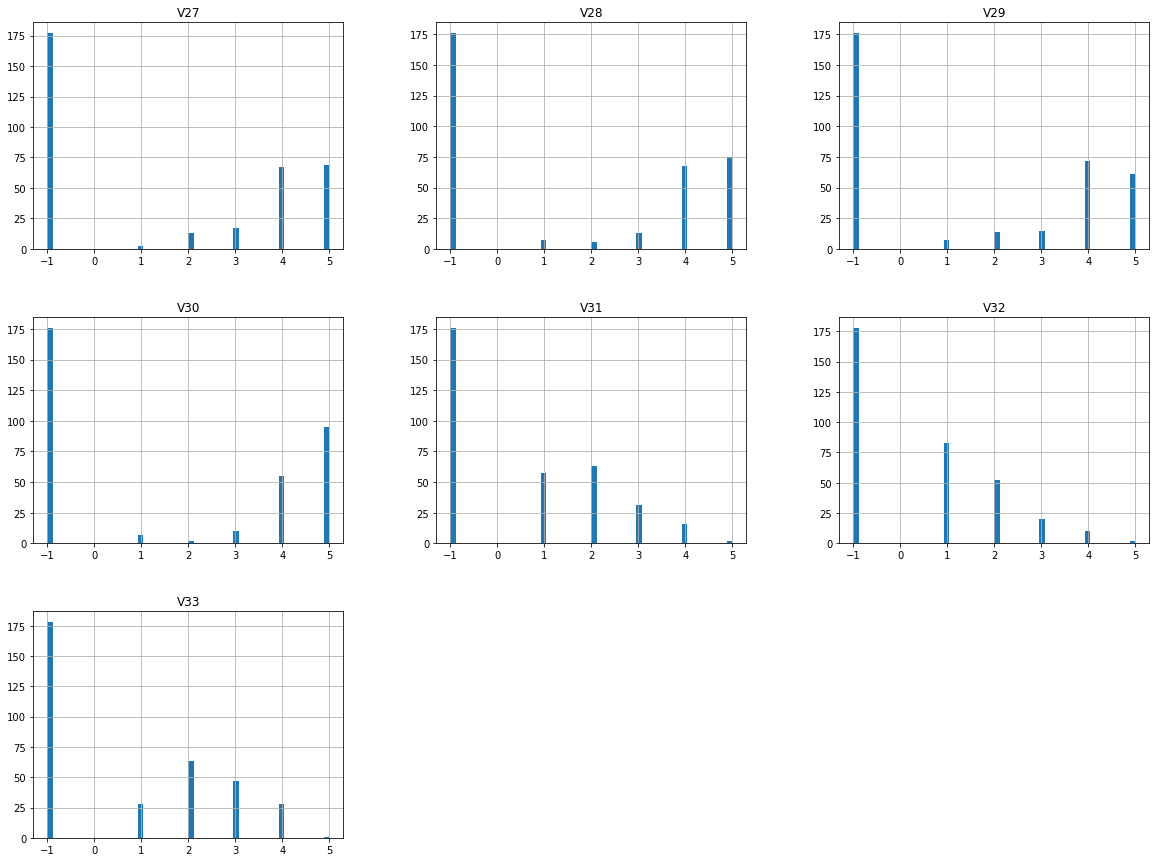

In [8]:
df.hist(column=df.columns[1:], bins=50, figsize=(20,15))
plt.show()

In [9]:
df[df.Community == 'Comm.FOSSASIA'].V27

0      4
1      5
2     -1
3     -1
4     -1
      ..
221   -1
223   -1
247    3
336   -1
366   -1
Name: V27, Length: 68, dtype: int64

In [10]:
# V27 = df[df.Community == 'Comm.FOSSASIA'].V27.to_numpy()
def removeNoAnswer(lst):
    return [int (i <= 3) for i in lst if i!=-1]
#    return lst[np.where(lst != -1)]

V27 = [removeNoAnswer(df[df.Community == community].V27.to_numpy()) for community in communities]
V28 = [removeNoAnswer(df[df.Community == community].V28.to_numpy())  for community in communities]
V29 = [removeNoAnswer(df[df.Community == community].V29.to_numpy())  for community in communities]
V30 = [removeNoAnswer(df[df.Community == community].V30.to_numpy())  for community in communities]
V31 = [removeNoAnswer(df[df.Community == community].V31.to_numpy())  for community in communities]
V32 = [removeNoAnswer(df[df.Community == community].V32.to_numpy())  for community in communities]
V33 = [removeNoAnswer(df[df.Community == community].V33.to_numpy())  for community in communities]
answers = [V27, V28, V29, V30, V31, V32, V33]

In [11]:
N = [len(V27), len(V28), len(V29), len(V30), len(V31), len(V32), len(V33)]
μ = [[np.mean(v) for v in V27], [np.mean(v) for v in V28], [np.mean(v) for v in V29],
     [np.mean(v) for v in V30], [np.mean(v) for v in V31], [np.mean(v) for v in V32], [np.mean(v) for v in V33]]
σ = [[np.std(v) for v in V27], [np.std(v) for v in V28], [np.std(v) for v in V29],
     [np.std(v) for v in V30], [np.std(v) for v in V31], [np.std(v) for v in V32], [np.std(v) for v in V33]]

# def standardize(data, m, sd):
#     return (data-m)/sd
# all_z = []
# for i in range(len(answers)):
#     lst=[]
#     for com in range(len(answers[i])):
#         z=standardize(answers[i][com], μ[i][com], σ[i][com])
#         lst.append(z)
#     all_z.append(lst)


In [12]:
np.array(answers).shape

<ipython-input-12-643bf9b24e26>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(answers).shape


(7, 13)

In [13]:
coalaIndex=np.where(communities=="Comm.Coala")[0][0]
linuxIndex=np.where(communities=="Comm.Linux_Kernel")[0][0]
z_coala=answers[6][coalaIndex]
z_linux=answers[6][linuxIndex]

μ_coala=μ[6][coalaIndex]
μ_linux=μ[6][linuxIndex]

σ_coala=σ[6][coalaIndex]
σ_linux=σ[6][linuxIndex]

print(z_coala,z_linux)
print("μ: ",μ_coala,μ_linux)
print("σ: ",σ_coala,σ_linux)

[1, 1, 1, 1, 1, 1, 1] [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
μ:  1.0 0.7222222222222222
σ:  0.0 0.4479032082388083


In [20]:
# put the model code 
with pm.Model() as model_h1:
    μ_noData = pm.Normal('μ_noData', mu=1, sigma=100*1, shape=1)
    μ        = pm.Deterministic('μ', μ_noData*μ_coala)
    σ_noData = pm.Uniform('σ_noData', lower=1/1000, upper=1*1000, shape=1)
    σ        = pm.Deterministic('σ', σ_noData*σ_coala)
    ν_minus_one = pm.Exponential('ν_minus_one', lam=1/29)
    ν = pm.Deterministic('ν', ν_minus_one+1)
    
    # for plotting/comparison purposes
    log10_ν = pm.Deterministic('log10_ν',np.log10(ν))
    eff_size = pm.Deterministic('eff_size',(μ-100)/σ)

    #likelihood
    obs_coala   = pm.StudentT('obs_coala',  nu=ν,mu=μ,sd=σ,observed=z_coala)
    #dif = pm.Deterministic('dif',abs(obs_coala-obs_linux))

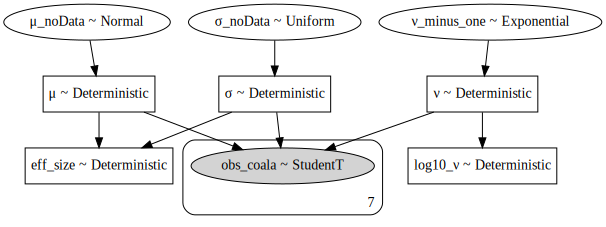

In [15]:
pm.model_to_graphviz(model_h1)

In [28]:
# sampling: uncomment
with model_h1:
    trace_h1=pm.sample(10000,chains=4, model=model_h1, cores=1, step=pm.NUTS())
    # storing trace, since I am not waiting that long again
    folderName ="h1.trace"
    pm.save_trace(trace_h1, folderName, overwrite=True)
    trace_h1 = pm.load_trace(folderName, model=model_h1)

Sequential sampling (4 chains in 1 job)
NUTS: [ν_minus_one, σ_noData, μ_noData]
Sampling chain 0, 0 divergences:   0%|                                                       | 0/10500 [00:00<?, ?it/s]


SamplingError: Bad initial energy

In [24]:
model_h1.check_test_point()

μ_noData              -5.52
σ_noData_interval__   -1.39
ν_minus_one_log__     -1.06
obs_coala              -inf
Name: Log-probability of test_point, dtype: float64

In [25]:
az.summary(trace_h1)

C:\Users\Stha\miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_noData[0],1.000,0.0,1.000,1.000,0.0,0.0,40000.0,40000.0,40000.0,40000.0,NaN
μ[0],1.000,0.0,1.000,1.000,0.0,0.0,40000.0,40000.0,40000.0,40000.0,NaN
σ_noData[0],500.000,0.0,500.000,500.000,0.0,0.0,40000.0,40000.0,40000.0,40000.0,NaN
σ[0],0.000,0.0,0.000,0.000,0.0,0.0,40000.0,40000.0,40000.0,40000.0,NaN
ν_minus_one,20.101,0.0,20.101,20.101,0.0,0.0,40000.0,40000.0,40000.0,40000.0,NaN
ν,21.101,0.0,21.101,21.101,0.0,0.0,40000.0,40000.0,40000.0,40000.0,NaN
log10_ν,1.324,0.0,1.324,1.324,0.0,0.0,40000.0,40000.0,40000.0,40000.0,NaN
eff_size[0],-inf,NaN,-inf,-inf,NaN,NaN,NaN,NaN,40000.0,40000.0,NaN


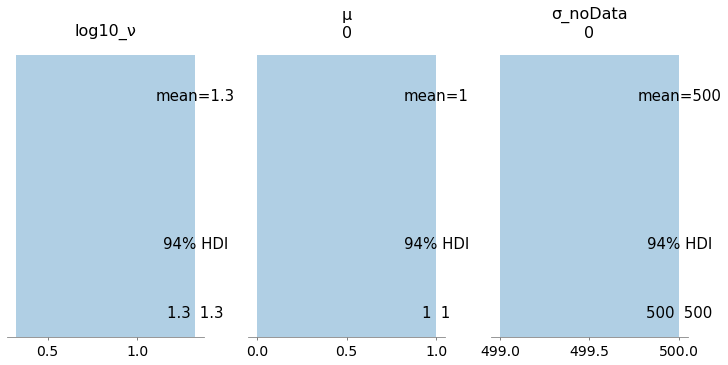

In [32]:
trace_h1_inferencedata = az.from_pymc3(trace_h1,model=model_h1)
pm.plot_posterior(trace_h1_inferencedata, 
                  var_names=['log10_ν', 'μ', 'σ_noData'], 
                  kind='hist',
                  figsize=(10,5));

In [ ]:
print(az.__version__)
print(pm.__version__)
print(theano.__version__)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345 entries, 0 to 379
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         345 non-null    int64 
 1   Community  345 non-null    object
 2   V27        345 non-null    int64 
 3   V28        345 non-null    int64 
 4   V29        345 non-null    int64 
 5   V30        345 non-null    int64 
 6   V31        345 non-null    int64 
 7   V32        345 non-null    int64 
 8   V33        345 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 27.0+ KB
